# Transformers - IMDB

Example taken from: <br>
https://keras.io/examples/nlp/text_classification_with_transformer/

The Multi Head attention can be exapanded, this example is aimed at working on local machines with GPU

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-06-19 11:22:07.440249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Transformer block

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Tokens and Positional Embedding

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Dpwnload the IMDB Dataset

In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


## Build Model

In [5]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2023-06-19 11:22:36.531150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 11:22:36.535450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 11:22:36.535653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 11:22:36.537527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-19 11:22:36.537723: I tensorflow/compile

## Fit model

In [6]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_val, y_val))

Epoch 1/4


2023-06-19 11:22:50.708096: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd70d0fc8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 11:22:50.708138: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-06-19 11:22:50.711519: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-19 11:22:50.827949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-19 11:22:50.911257: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 58s 69ms/step - loss: 0.3836 - accuracy: 0.8199 - val_loss: 0.2925 - val_accuracy: 0.8768
Epoch 2/4
782/782 [==============================] - 20s 26ms/step - loss: 0.1978 - accuracy: 0.9250 - val_loss: 0.3095 - val_accuracy: 0.8755
Epoch 3/4
782/782 [==============================] - 17s 22ms/step - loss: 0.1326 - accuracy: 0.9518 - val_loss: 0.3849 - val_accuracy: 0.8657
Epoch 4/4
782/782 [==============================] - 15s 19ms/step - loss: 0.0886 - accuracy: 0.9694 - val_loss: 0.4337 - val_accuracy: 0.8552


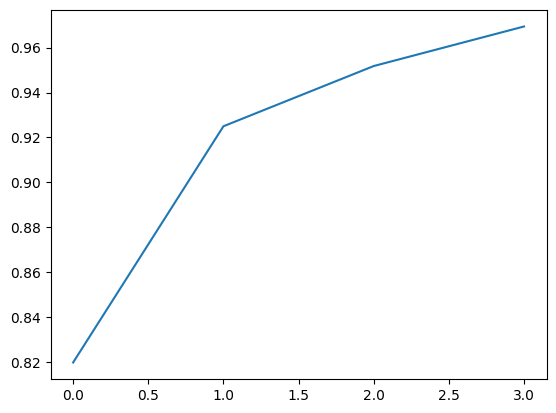

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.show()